# Customer churn

Customers began to leave "Beta Bank". Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We are presented with historical data on the behavior of customers and the termination of contracts with the bank.

It is necessary to build a model with an extremely large value of F1-measures. To pass the project successfully, we need to bring the metric to 0.59. Check the F1 measure on the test sample yourself.

Additionally measure AUC-ROC, compare its value with F1-measure.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Features:**

- `RowNumber` - row index in data;
- `CustomerId` - unique customer identifier;
- `Surname` - surname;
- `CreditScore` - credit rating;
- `Geography` - country of residence;
- `gender` - gender;
- `Age` - age;
- `Tenure` - how many years a person has been a bank client;
- `Balance` - account balance;
- `NumOfProducts` - the number of bank products used by the client;
- `HasCrCard` - the presence of a credit card;
- `IsActiveMember` - client activity;
- `EstimatedSalary` - estimated salary.

**Target feature:**

- `Exited` - the fact that the client left.

## Data preprocessing

The sample includes clients where:
- 79% - stayed with the bank;
- 20.4% - left the bank.

The data is rather unbalanced.
    
The bank's clients are residents of the following countries:
- France 50%;
- Germany 25%;
- Spain 25%.

There is a clear imbalance of classes in favor of the negative class. If we predict all people that they will not leave the bank then in 80% of cases we will be right.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('Churn.csv')
display(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
# no duplicates found
data.duplicated().sum()

0

There are missings in the data in the `"Tenure"` column. This is too individual a parameter to fill in the missings with some value.
It is necessary to check its dependence on customer care in order to decide what to do with it.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Distribution of clients by country')

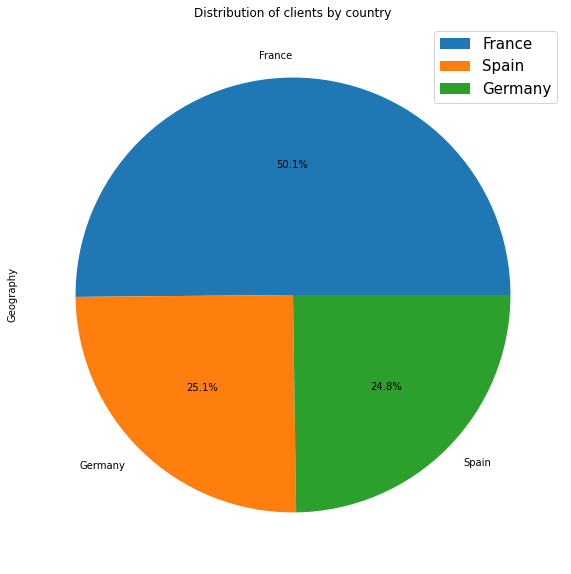

In [6]:
data['Geography'].value_counts().plot(kind='pie', autopct='%1.1f%%' , figsize=(10,10))
plt.legend(['France', 'Spain','Germany'], fontsize=15)
plt.title('Distribution of clients by country')

Text(0.5, 1.0, 'Clients')

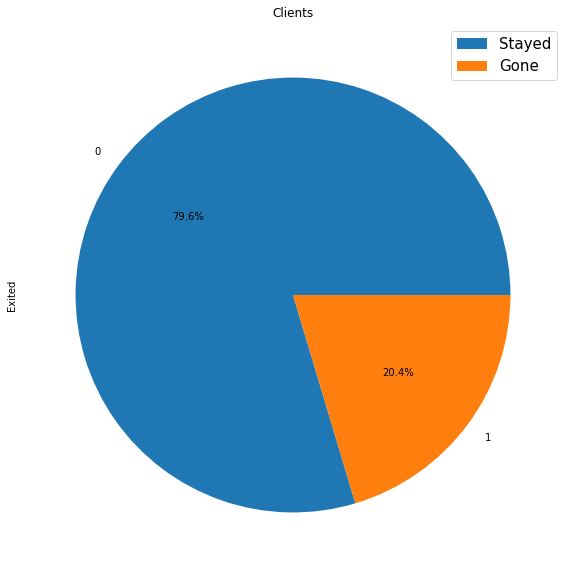

In [7]:
data['Exited'].value_counts().plot(kind='pie', autopct='%1.1f%%' , figsize=(10,10))
plt.legend(['Stayed', 'Gone'], fontsize=15)
plt.title('Clients')


## Task research

Leaving clients:

- low credit rating;
- less active;
- women;
- older people
- less balance;
- citizens of Germany;
- with a lower salary.

**How many customers LEFT and how many REMAIN depending on the country ?**

It can be seen that most of the customers left France.  Also France and Spain approximately the same percentage of those who left - 16%. But in Germany twice as many people left as a percentage.

In [8]:
data[['Geography','Exited']]
geography_outflow = data.pivot_table(index='Geography',values='Exited',columns=data['Exited'].values,aggfunc='count')
geography_outflow.columns = ['stay_in','outflow']
geography_outflow['fraction_outlay'] = geography_outflow['outflow'] / (geography_outflow['outflow'] + geography_outflow['stay_in'])
display(geography_outflow)

,stay_in,outflow,fraction_outlay
Geography,,,
France,4204,810,0.161548
Germany,1695,814,0.324432
Spain,2064,413,0.166734


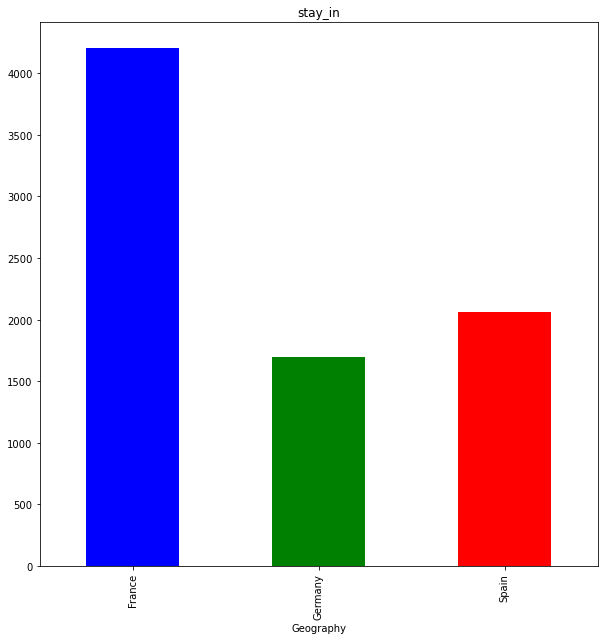

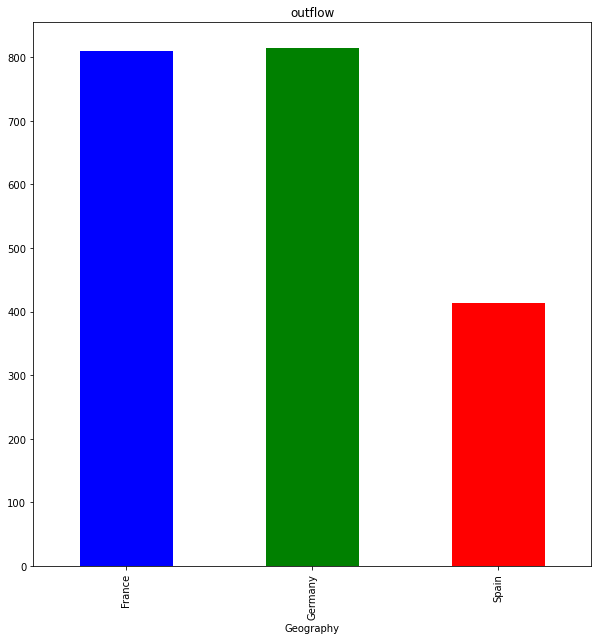

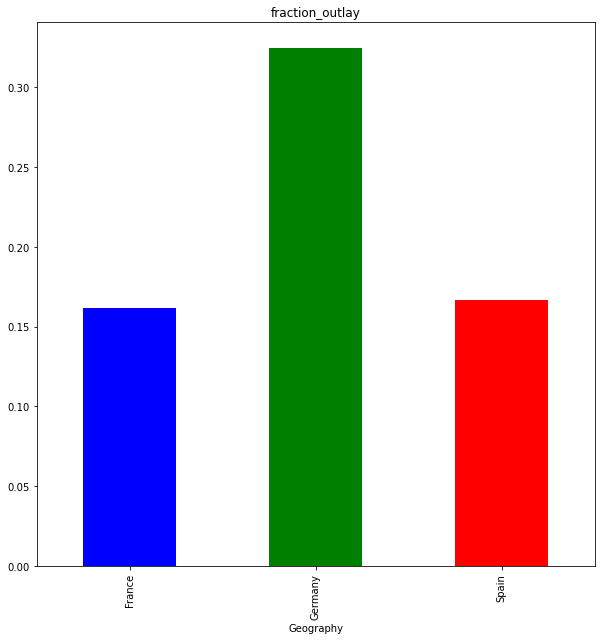

In [9]:
for i in geography_outflow.columns:
    geography_outflow[i].plot(kind='bar',color=['b','g','r'], figsize=(10,10))
    plt.title(i)
    plt.show()

**Percentage of "churn" in dependence on gender:**

More women leave than men.

In [10]:
data[['Gender','Exited']]
gender_outflow = data.pivot_table(index='Gender',values='Exited',columns=data['Exited'].values,aggfunc='count')
gender_outflow.columns = ['stay_in','outflow']
gender_outflow['fraction_outlay'] = gender_outflow['outflow'] / (gender_outflow['outflow'] + gender_outflow['stay_in'])
display(gender_outflow)

,stay_in,outflow,fraction_outlay
Gender,,,
Female,3404,1139,0.250715
Male,4559,898,0.164559


**Ratio of "churn" of clients depending on age:**

It can be seen that most people who leave the bank do so at the age of 45. And most of those who remain are 35 years old.

Text(0, 0.5, 'Number of clients')

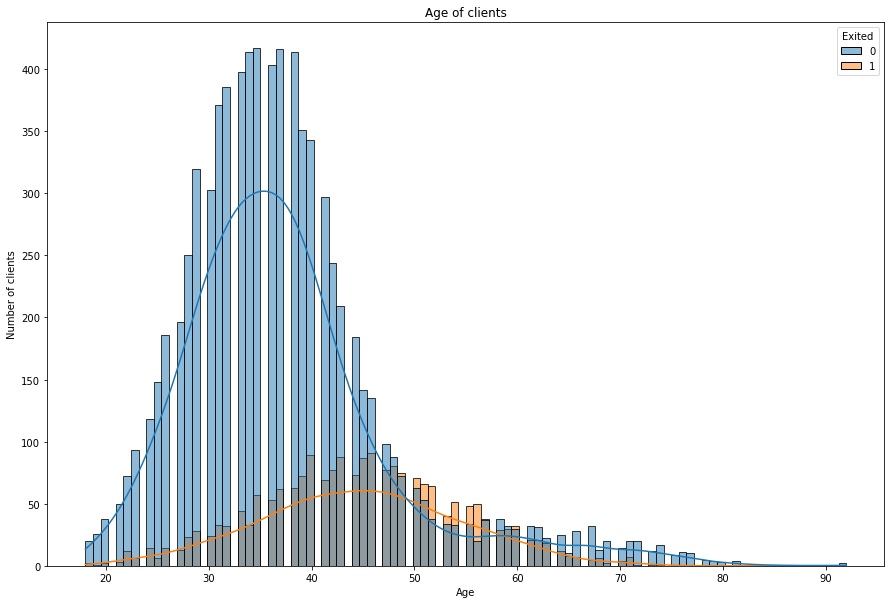

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
sb.histplot(data=data, x='Age', hue='Exited', kde=True, bins=100, ax=ax)
plt.title('Age of clients')
plt.xlabel('Age')
plt.ylabel('Number of clients')

**Customer "churn" ratio depending on the number of products used:**

According to the data it can be concluded that those people who use TWO applications in contrast to those who use 1,3,4 applications remain the bank's customers.

In [12]:
data[['NumOfProducts','Exited']]
NumOfProducts_outflow = data.pivot_table(index='NumOfProducts',values='Exited',columns=data['Exited'].values,aggfunc='count')
NumOfProducts_outflow.columns = ['stay_in','outflow']
NumOfProducts_outflow['fraction_outlay'] = NumOfProducts_outflow['outflow'] / (NumOfProducts_outflow['outflow'] + NumOfProducts_outflow['stay_in'])
display(NumOfProducts_outflow)

,stay_in,outflow,fraction_outlay
NumOfProducts,,,
1,3675.0,1409.0,0.277144
2,4242.0,348.0,0.075817
3,46.0,220.0,0.827068
4,NaN,60.0,NaN


**Customer churn ratio depending on their salary:**

Clients who leave earn less than those who stay. The difference is 4 times. Perhaps this is due to the fact that customers who earn little are looking for more favorable conditions.

Text(0, 0.5, 'Number of clients')

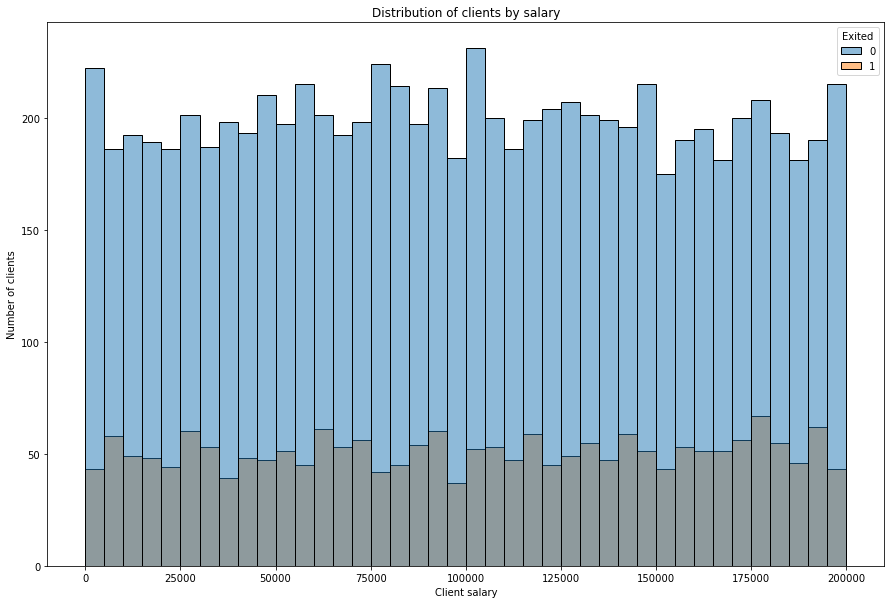

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
sb.histplot(data=data, x='EstimatedSalary',hue='Exited',bins=40, ax=ax)
plt.title('Distribution of clients by salary')
plt.xlabel('Client salary')
plt.ylabel('Number of clients')

Those who leave have a lower credit rating than those who stay with the bank.

Text(0, 0.5, 'Number of clients')

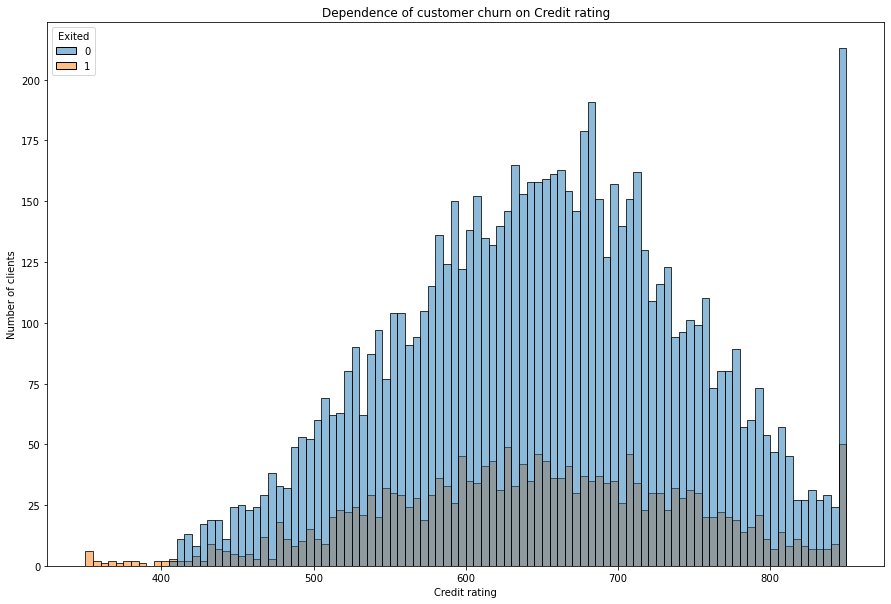

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

sb.histplot(data=data, x='CreditScore', hue='Exited', bins=100, ax=ax)
plt.title('Dependence of customer churn on Credit rating')
plt.xlabel('Credit rating')
plt.ylabel('Number of clients')

**Dependence of Customer churn on the number of years that a person has been a client of the bank:**

The churn rate is almost the same. This feature can be removed. No relationship.

In [15]:
data[['Tenure','Exited']]

Tenure_outflow = data.pivot_table(index='Tenure',values='Exited',\
                                  columns=data['Exited'].values,aggfunc='count')

Tenure_outflow.columns = ['stay_in','outflow']

Tenure_outflow['fraction_outlay'] =\
                Tenure_outflow['outflow'] / (Tenure_outflow['outflow'] + Tenure_outflow['stay_in'])

display(Tenure_outflow)

,stay_in,outflow,fraction_outlay
Tenure,,,
0.0,292,90,0.235602
1.0,739,213,0.223739
2.0,765,185,0.194737
3.0,730,198,0.213362
4.0,701,184,0.207910
5.0,740,187,0.201726
6.0,704,177,0.200908
7.0,765,160,0.172973
8.0,759,174,0.186495


**Dependence of  Customer churn on the cash account in the bank:**

Leaving people with less cash account.

Text(0, 0.5, 'Number of people')

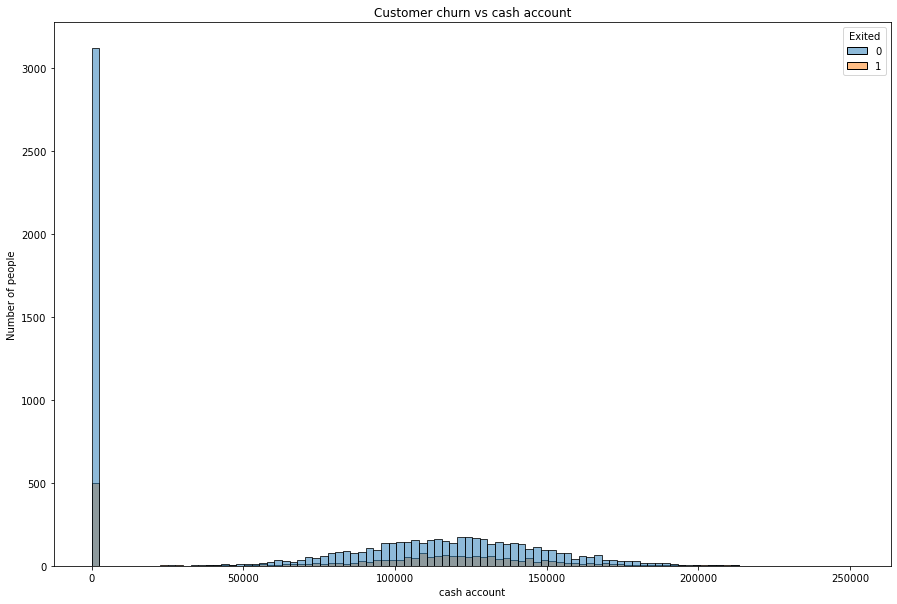

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sb.histplot(data=data, x='Balance',hue='Exited',bins=100, ax=ax)
plt.title('Customer churn vs cash account')
plt.xlabel('cash account')
plt.ylabel('Number of people')

The ratio shows that less active customers are leaving - 6%.

In [17]:
data[['IsActiveMember','Exited']]

IsActiveMember_outflow = data.pivot_table(index='IsActiveMember',\
                                values='Exited',columns=data['Exited'].values,aggfunc='count')

IsActiveMember_outflow.columns = ['stay_in','outflow']

IsActiveMember_outflow['fraction_outlay'] =\
                            IsActiveMember_outflow['outflow'] / (IsActiveMember_outflow['outflow'] +\
                            IsActiveMember_outflow['stay_in'])

display(IsActiveMember_outflow)

,stay_in,outflow,fraction_outlay
IsActiveMember,,,
0,3547,1302,0.268509
1,4416,735,0.142691


The ratio shows that there is no special relationship between outgoing and the presence of a credit card. The FEATURE may not be used.

In [18]:
data[['HasCrCard','Exited']]

HasCrCard_outflow = data.pivot_table(index='HasCrCard',values='Exited',\
                                     columns=data['Exited'].values, aggfunc='count')

HasCrCard_outflow.columns = ['stay_in','outflow']

HasCrCard_outflow['fraction_outlay'] =\
                                HasCrCard_outflow['outflow'] / (HasCrCard_outflow['outflow'] +\
                                HasCrCard_outflow['stay_in'])

display(HasCrCard_outflow)

,stay_in,outflow,fraction_outlay
HasCrCard,,,
0,2332,613,0.208149
1,5631,1424,0.201843


In [19]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Let's train several models on an unbalanced sample.

In [20]:
data1 = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data_ohe = pd.get_dummies(data1, drop_first=True)
data_ohe = data_ohe.dropna()

In [21]:
# creation training, validation and test samples (70/15/15)
data_train, data_valid, data_test = np.split(data_ohe, [int(0.7 * len(data)), int(0.85 * len(data))])

In [22]:
# creation training sample with features
features_train = data_train.drop(['Exited'], axis=1)
# creation training sample with target features
target_train = data_train['Exited']

# creation validation sample with features
features_valid = data_valid.drop(['Exited'], axis=1)
# creation validation sample with target features
target_valid = data_valid['Exited']

# creation test sample with features
features_test = data_test.drop(['Exited'], axis=1)
# creation test sample with target features
target_test = data_test['Exited']

**In an unbalanced validation set the tree has an accuracy of 57%. This is not enough**
    
- f1 - 0.58
- depth - 9
- execution time - 0.154 s

In [23]:
# unbalanced selection tree
start_time = time.time()
a = 0
b = 0.577
model_tree = None
for y in range(1,30):
    model_tree = DecisionTreeClassifier(max_depth=y, random_state=12345)
    model_tree = model_tree.fit(features_train, target_train)
    prediction = model_tree.predict(features_valid)
    #print(prediction.round())
    a = f1_score(target_valid,prediction.round())
    if a > b:
        print (f'f1_score = {a}')
        print(f'n_estim = {i},depth = {y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break

f1_score = 0.5771324863883848
n_estim = fraction_outlay,depth = 9
--- 0.12363815307617188 seconds ---



In an unbalanced validation set the random forest has an accuracy of 60%. This is sufficient for the condition of the problem.
    
- f1 - 0.61;
- number of trees - 12;
- depth - 15;
- execution time - 19.9 s.

In [24]:
# random forest with unbalanced sample
start_time = time.time()
model_random_forest = None
for i in range(1,100): 
    a = 0
    b = 0.60
    for y in range(1,20):
        model_random_forest = RandomForestRegressor(n_estimators=i,max_depth=y, random_state=12345)
        model_random_forest.fit(features_train, target_train)
        model_random_forest = model_random_forest
        prediction = model_random_forest.predict(features_valid)
        #print(prediction.round())
        a = f1_score(target_valid,prediction.round())
        if a > b:
            break
    if a > b:
        print (f'f1_score = {a}')
        print(f'n_estim = {i},depth = {y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break

f1_score = 0.6106870229007633
n_estim = 12,depth = 15
--- 14.568325281143188 seconds ---



In [25]:
# разделили на выборки
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']
features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size=0.25,random_state=12345)

**Now let's test our algorithms on a test unbalanced sample.**

The models showed weak results.
Presumably, the models were overfitted by the training sample.
    
Trees:
- 0.505

Random forest:
- 0.534

In [26]:
# tree with unbalanced test sample
start_time = time.time()

prediction = model_tree.predict(features_test)
#print(prediction.round())
a = f1_score(target_test,prediction.round())
print (f'f1_score = {a}')

print("--- %s seconds ---" % (time.time() - start_time))
print('')   



f1_score = 0.5052631578947369
--- 0.007035493850708008 seconds ---



In [27]:
# random forest with unbalanced test sample
start_time = time.time()

prediction = model_random_forest.predict(features_test)
#print(prediction.round())
a = f1_score(target_test,prediction.round())

print (f'f1_score = {a}')
print("--- %s seconds ---" % (time.time() - start_time))
print('')   

f1_score = 0.5340909090909091
--- 0.010933160781860352 seconds ---



## Imbalance decision

Prepare data for training. It is important to remove unrepresentative features:
    
- tenure;
- HasCrCard;
- CustomerId;
- Surname;
- RowNumber.
    
At this point, variables were coded for training models using the OHE method. We also balanced our samples using the upsampling method.

In [28]:
# coded and removed missings in the "tenure" column
data2 = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data_ohe = pd.get_dummies(data2, drop_first=True)
data_ohe = data_ohe.dropna()

In [29]:
# creation training, validation and test samples (70/15/15)
data_train, data_valid, data_test = np.split(data_ohe, [int(0.7 * len(data)), int(0.85 * len(data))])

In [30]:
# creation training sample with features
features_train = data_train.drop(['Exited'], axis=1)
# creation training sample with target features
target_train = data_train['Exited']

# creation validation sample with features
features_valid = data_valid.drop(['Exited'], axis=1)
# creation validation sample with target features
target_valid = data_valid['Exited']

# creation test sample with features
features_test = data_test.drop(['Exited'], axis=1)
# creation test sample with target features
target_test = data_test['Exited']

In [31]:
# let's create a function that will remove the imbalance of classes using the upsampling method.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [32]:
# no class imbalance
features_upsampled,target_upsampled = upsample(features_train,target_train,4)

It is necessary to apply other ways to deal with the imbalance is downsampling.

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [34]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.27)

Train models on samples without imbalance
    
Tree, balanced sampling, upsampling:
    
- f1 - 0.577
- depth - 5
- execution time - 0.076 seconds
    
Tree, balanced sampling, downsampling:
    
- f1 - 0.565
- depth - 4
- execution time - 0.03 seconds
    
Random forest, balanced sampling, upsampling:
    
- f1 - 0.611
- trees - 10,
- depth - 9
- execution time - 17.6 seconds
    
  Random forest, balanced sampling, downsampling:
    
- f1 - 0.606
- trees - 11,
- depth - 5
- execution time - 7.55 seconds

`Best model` - model_random_forest_up (Random forest, balanced sampling, upsampling)

In [35]:
# tree on balanced sample with upsampling
start_time = time.time()
a = 0
b = 0.57
model_tree_up = None
for y in range(1,30):
    model_tree_up = DecisionTreeClassifier(max_depth=y, random_state=12345)
    model_tree_up.fit(features_upsampled, target_upsampled)
    model_tree_up = model_tree_up
    prediction = model_tree_up.predict(features_valid)
    #print(prediction.round())
    a = f1_score(target_valid,prediction.round())
    if a > b:
        print (a)
        print(f'depth={y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break


0.5771144278606966
depth=5
--- 0.07076287269592285 seconds ---



In [36]:
# tree on balanced sample with downsampling
start_time = time.time()
a = 0
b = 0.565
model_tree_down = None
for y in range(1,30):
    model_tree_down = DecisionTreeClassifier(max_depth=y, random_state=12345)
    model_tree_down = model_tree_down.fit(features_downsampled, target_downsampled)
    model_tree_down = model_tree_down
    prediction = model_tree_down.predict(features_valid)
    a = f1_score(target_valid,prediction.round())
    if a > b:
        print (f'f1_score = {a}')
        print(f'depth={y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break


f1_score = 0.5653798256537983
depth=4
--- 0.031894683837890625 seconds ---



In [37]:
# random forest on balanced sample with upsampling
start_time = time.time()
model_random_forest_up = None
for i in range(1,100): 
    a = 0
    b = 0.61
    for y in range(1,20):
        model_random_forest_up = RandomForestClassifier(n_estimators=i,max_depth=y, random_state=12345)
        model_random_forest_up.fit(features_upsampled, target_upsampled)
        model_random_forest_up = model_random_forest_up
        prediction = model_random_forest_up.predict(features_valid)
        #print(prediction.round())
        a = f1_score(target_valid,prediction.round())
        if a > b:
            break
    if a > b:
        print (f'f1_score = {a}')
        print(f'n_estim={i},depth={y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break
        

f1_score = 0.6129032258064516
n_estim=8,depth=9
--- 4.268772125244141 seconds ---



In [38]:
# random forest on balanced sample with downsampling
start_time = time.time()
model_random_forest_down = None
for i in range(1,100): 
    a = 0
    b = 0.60
    for y in range(1,20):
        model_random_forest_down = RandomForestRegressor(n_estimators=i,max_depth=y, random_state=12345)
        model_random_forest_down.fit(features_downsampled, target_downsampled)
        model_random_forest_down = model_random_forest_down
        prediction = model_random_forest_down.predict(features_valid)
        #print(prediction.round())
        a = f1_score(target_valid,prediction.round())
        if a > b:
            break
    if a > b:
        print (f'f1_score = {a}')
        print(f'n_estim={i},depth={y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break

f1_score = 0.6060606060606061
n_estim=11,depth=5
--- 5.34917950630188 seconds ---



## Model testing

We chek the test sample on the best model (model_random_forest_up (Random forest, balanced sample, upsampling))
The model showed relatively good results f1 - 0.5917 . There is no retraining.

In [39]:
# random forest on balanced sample with upsampling
start_time = time.time()
prediction1 = model_random_forest_up.predict(features_test)
#print(prediction.round())
a = f1_score(target_test,prediction1.round())
print (f'f1_score = {a}')
print("--- %s seconds ---" % (time.time() - start_time))        

f1_score = 0.5991902834008097
--- 0.007972002029418945 seconds ---


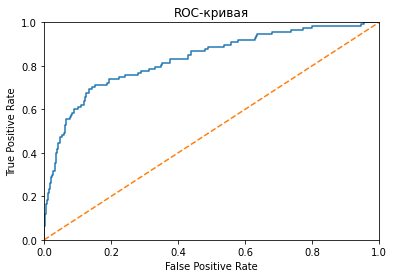

In [40]:
probabilities_valid = model_random_forest_up.predict_proba(features_test)

probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr, linestyle='-')

# ROC-curve of a random model
plt.plot([0, 1], [0, 1], linestyle='--')


plt.xlim([0,1])
plt.ylim([0,1])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title('ROC-кривая')
plt.show()


In [41]:
auc_roc = roc_auc_score(target_test,probabilities_one_valid)

In [42]:
print(auc_roc)

0.83040027605245


**`FINAL CONCLUSION`**
    
Best model - model_random_forest_up (Random forest, balanced sampling, upsampling)
    
Random forest, balanced sampling, upsampling:
    
- f1 - 0.611
- trees - 10,
- depth - 9
- execution time - 17.6 seconds
    
A complete analysis of the data was carried out. The models were tested on balanced and unbalanced data.
Balanced data performed better. We also used OHE. Model-check was carried out on a test sample. No overfitting was found on the best model.